### Notebook dependencies

In [1]:
!pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2


In [13]:
!python -m site

sys.path = [
    '/kaggle/working',
    '/kaggle/lib/kagglegym',
    '/kaggle/lib',
    '/opt/conda/lib/python310.zip',
    '/opt/conda/lib/python3.10',
    '/opt/conda/lib/python3.10/lib-dynload',
    '/root/.local/lib/python3.10/site-packages',
    '/opt/conda/lib/python3.10/site-packages',
    '/root/src/BigQuery_Helper',
]
USER_BASE: '/root/.local' (exists)
USER_SITE: '/root/.local/lib/python3.10/site-packages' (exists)
ENABLE_USER_SITE: True


In [2]:
cd /opt/conda/lib/python3.10/site-packages

/opt/conda/lib/python3.10/site-packages


In [3]:
rm -rf aiohttp*

In [16]:
pip list

Package                                  Version            Editable project location
---------------------------------------- ------------------ -------------------------
absl-py                                  1.4.0
accelerate                               0.30.1
access                                   1.1.9
affine                                   2.4.0
aiobotocore                              2.13.0
aiofiles                                 22.1.0
aioitertools                             0.11.0
aiorwlock                                1.3.0
aiosignal                                1.3.1
aiosqlite                                0.19.0
albumentations                           1.4.0
alembic                                  1.13.1
altair                                   5.3.0
annotated-types                          0.6.0
annoy                                    1.17.3
anyio                                    4.2.0
apache-beam                              2.46.0
aplus                

In [5]:
!pip cache purge

Files removed: 20


In [4]:
!pip install trl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:0000:01


In [5]:
!pip install --no-cache-dir transformers sentencepiece


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: --Y


In [6]:
import logging
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.optim as optim
import random
from matplotlib import pyplot as plt
import numpy as np
from trl import PPOConfig, AutoModelForSeq2SeqLMWithValueHead, PPOTrainer, create_reference_model
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer
from trl.core import respond_to_batch
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [7]:
dataset = load_dataset("aadityaubhat/GPT-wiki-intro")
dataset

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'wiki_intro', 'generated_intro', 'title_len', 'wiki_intro_len', 'generated_intro_len', 'prompt', 'generated_text', 'prompt_tokens', 'generated_text_tokens'],
        num_rows: 150000
    })
})

In [8]:
df = pd.DataFrame(dataset['train'])
df.to_csv('WikiDataset.csv')
copy_df = df.copy()
df.head()

,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
0,63064638,https://en.wikipedia.org/wiki/Sexhow%20railway...,Sexhow railway station,Sexhow railway station was a railway station b...,Sexhow railway station was a railway station l...,3,174,78,200 word wikipedia style introduction on 'Sexh...,"located in the town of Sexhow, on the Cumbria...",25,88
1,279621,https://en.wikipedia.org/wiki/Eti%C3%A4inen,Etiäinen,"In Finnish folklore, all places and things, an...","In Finnish folklore, all places and things, an...",1,187,80,200 word wikipedia style introduction on 'Etiä...,"animate or inanimate, have a spirit or ""etiäi...",26,101
2,287229,https://en.wikipedia.org/wiki/Inverse%20functi...,Inverse function theorem,"In mathematics, specifically differential calc...","In mathematics, specifically differential calc...",3,170,59,200 word wikipedia style introduction on 'Inve...,function theorem states that for every real-v...,26,65
3,26712375,https://en.wikipedia.org/wiki/Stepping%20on%20...,Stepping on Roses,is a Japanese shōjo manga series written and i...,is a Japanese shōjo manga series written and i...,3,335,121,200 word wikipedia style introduction on 'Step...,and illustrated by Maki Fujii. The series fol...,26,150
4,38894426,https://en.wikipedia.org/wiki/Rob%20Bradley,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...","Robert Milner ""Rob"" Bradley, Jr. (born August ...",2,170,136,200 word wikipedia style introduction on 'Rob ...,"29, 1973) is an American former professional ...",28,162


In [10]:
# Validation set -> 10%
validate_df = copy_df.sample(n=int(0.1 * len(df)), random_state=42)
copy_df = copy_df.drop(validate_df.index)
validate_df = validate_df.sample(frac=1).reset_index(drop=True)
validate_df.head(10)

,id,url,title,wiki_intro,generated_intro,title_len,wiki_intro_len,generated_intro_len,prompt,generated_text,prompt_tokens,generated_text_tokens
59770,28309756,https://en.wikipedia.org/wiki/Benetton%20B187,Benetton B187,The Benetton B187 is a Formula One racing car ...,The Benetton B187 is a Formula One racing car ...,2,180,82,200 word wikipedia style introduction on 'Bene...,racing car designed by Benetton for the 1987 ...,28,101
21362,2387525,https://en.wikipedia.org/wiki/Heliodisplay,Heliodisplay,The Heliodisplay is an air-based display using...,The Heliodisplay is an air-based display using...,1,322,29,200 word wikipedia style introduction on 'Heli...,a mirror to reflect sunlight onto a screen. I...,29,25
127324,15214263,https://en.wikipedia.org/wiki/MTCH1,MTCH1,"Mitochondrial carrier homolog 1 (MTCH1), also ...","Mitochondrial carrier homolog 1 (MTCH1), also ...",1,167,176,200 word wikipedia style introduction on 'MTCH...,to as human mitochondrial carrier protein 1 (...,30,230
140509,636846,https://en.wikipedia.org/wiki/Calluna,Calluna,"Calluna vulgaris, common heather, ling, or sim...","Calluna vulgaris, common heather, ling, or sim...",1,174,112,200 word wikipedia style introduction on 'Call...,"heather, is a species of flowering plant in t...",28,139
144297,36667499,https://en.wikipedia.org/wiki/Berea%E2%80%93Mi...,Berea–Midpark High School,Berea–Midpark High School (BMHS) is a public h...,Berea–Midpark High School (BMHS) is a public h...,3,164,152,200 word wikipedia style introduction on 'Bere...,"high school located in Berea, Ohio, United St...",35,227
96370,8776164,https://en.wikipedia.org/wiki/Sparta%20Amfi,Sparta Amfi,Sparta Amfi is an indoor ice hockey rink locat...,Sparta Amfi is an indoor ice hockey rink locat...,2,198,48,200 word wikipedia style introduction on 'Spar...,"rink located in Sparta, Greece. The rink is t...",27,56
49742,64656506,https://en.wikipedia.org/wiki/Jagdish%20Mahto,Jagdish Mahto,Jagdish Mahto was a naxal leader who led the B...,Jagdish Mahto was a naxal leader who was activ...,2,270,193,200 word wikipedia style introduction on 'Jagd...,was active in the 1970s and 1980s. He was kno...,31,249
47389,31806743,https://en.wikipedia.org/wiki/Barbara%20F.%20Lee,Barbara F. Lee,"Barbara Fish Lee (born July 3, 1945) is an Ame...","Barbara Fish Lee (born July 3, 1945) is an Ame...",3,229,249,200 word wikipedia style introduction on 'Barb...,is an American lawyer and diplomat who served...,28,300
58378,1856662,https://en.wikipedia.org/wiki/Volodymyr%20Anto...,Volodymyr Antonovych,Volodymyr Antonovych (Ukrainian: Володимир Бон...,Volodymyr Antonovych (Ukrainian: Володимир Бон...,2,182,221,200 word wikipedia style introduction on 'Volo...,Volodymyr Antonovych Antonovych; born 20 Octo...,73,300
69047,32939850,https://en.wikipedia.org/wiki/Tiit,Tiit,Tiit is predominantly an Estonian masculine gi...,Tiit is predominantly an Estonian masculine gi...,1,195,129,200 word wikipedia style introduction on 'Tiit...,"name, derived from the Estonian word ""tii"", m...",24,191


### Attacker - Paraphraser
https://huggingface.co/eugenesiow/bart-paraphrase

In [15]:
paraphraser_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained('eugenesiow/bart-paraphrase')
paraphraser_tokenizer = AutoTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
paraphraser_tokenizer.pad_token = paraphraser_tokenizer.eos_token
para_ref = create_reference_model(paraphraser_model)

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

### Detector - RoBERTa
https://huggingface.co/roberta-large-openai-detector

In [16]:
detector_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-openai-detector")
detector_tokenizer = AutoTokenizer.from_pretrained("roberta-large-openai-detector")
detector_model

config.json:   0%|          | 0.00/519 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [17]:
# returns 1 for AI-generated and 0 otherwise
def classify_text(text):
    inputs = detector_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        output = detector_model(**inputs)
    return 1 if output.logits[0][0] > output.logits[0][1] else 0 

In [42]:
classify_text("Sexhow railway station was a railway station located in the town of Sexhow, on the Cumbrian Coast Line in North West England. The station was opened by the Lancashire and Yorkshire Railway on 7 October 1870. It was closed to passengers on 5 January 1950, and to goods on 12 May 1965. The station building is now a private residence. There is a small amount of trackage remaining near the building, used currently by a local agricultural business.")

0


### GAN-like training

In [18]:
max_steps = 2700 
batch_size = 200 
learning_rate = 1e-5
epsilon = 0.2
gamma = 1.0
lambda_val = 0.1

human_text = list(copy_df['wiki_intro'])
AI_text = list(copy_df['generated_intro'])

paraphraser_optimizer = optim.Adam(paraphraser_model.parameters(), lr=learning_rate)

In [20]:
# Setup
ppo_config = PPOConfig(
    batch_size=1,
    mini_batch_size=1,
    steps = 20000,
    learning_rate = 1e-5,
    lam = 0.95,
)
ppotrainersteps = []
loss_detector = []

In [21]:
def get_paraphrase(text, paraphraser_model, paraphraser_tokenizer):
    inputs = paraphraser_tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    paraphraser_model.eval()
    beam_outputs = paraphraser_model.generate(
        input_ids=inputs['input_ids'], 
        attention_mask=inputs['attention_mask'],
        max_length=1000,
        early_stopping=True,
        num_beams=4,
        num_return_sequences=1
    )
    
    return paraphraser_tokenizer.decode(beam_outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

In [82]:
paraphrase = get_paraphrase("Sexhow railway station was a railway station located in the town of Sexhow, on the Cumbrian Coast Line in North West England. The station was opened by the Lancashire and Yorkshire Railway on 7 October 1870. It was closed to passengers on 5 January 1950, and to goods on 12 May 1965. The station building is now a private residence. There is a small amount of trackage remaining near the building, used currently by a local agricultural business.", paraphraser_model, paraphraser_tokenizer)
paraphrase

'Sexhow railway station was a railway station in the town of Sexhow, on the Cumbrian Coast Line, opened on 7 October 1870 by the Lancashire and Yorkshire Railway and closed on 12 May 1965. The station building is now a private residence.'

In [22]:
for step in range(max_steps):
    x_h = human_text[np.random.randint(len(human_text))]
    x_m = AI_text[np.random.randint(len(AI_text))]

    # Train the paraphraser(attacker) model
    paraphrased_text = get_paraphrase(x_m, paraphraser_model, paraphraser_tokenizer)
    ip = detector_tokenizer(paraphrased_text, return_tensors="pt", padding=True, truncation=True)
    op = detector_model(**ip)
    reward = torch.tensor(torch.nn.functional.softmax(op.logits)[0][0].item())

    paraphraser_model.train()
    paraphraser_optimizer.zero_grad()

    x_p_texts = paraphrased_text
    query_tensor = paraphraser_tokenizer(x_m, return_tensors="pt")
    resp_tensor = paraphraser_tokenizer(x_p_texts, return_tensors="pt")['input_ids']

    ppo_trainer = PPOTrainer(ppo_config, paraphraser_model, para_ref, paraphraser_tokenizer)

    train_stats = ppo_trainer.step([query_tensor['input_ids'][0]], [resp_tensor[0]], [reward])

    print(f"Reward: {reward}")
    print(f"PPO Val Loss : {train_stats['ppo/loss/value']}")
    ppotrainersteps.append(train_stats['ppo/loss/value'])
    
    # Train the detector model
    detector_model.train()
    optimizer = optim.AdamW(detector_model.parameters(), lr=learning_rate)

    labels_h = torch.zeros(1, dtype=torch.long)
    labels_m = torch.ones(1, dtype=torch.long)

    inputs_h = detector_tokenizer([x_h], return_tensors="pt", padding=True, truncation=True)
    inputs_m = detector_tokenizer([x_p_texts], return_tensors="pt", padding=True, truncation=True)

    outputs = detector_model(input_ids=inputs_h['input_ids'], attention_mask=inputs_h['attention_mask'], labels=labels_h)
    loss_h = outputs.loss

    outputs = detector_model(input_ids=inputs_m['input_ids'], attention_mask=inputs_m['attention_mask'], labels=labels_m)
    loss_m = outputs.loss

    loss = loss_h + lambda_val * loss_m

    print(f"Loss at iteration {step} : {loss.item()}")
    loss_detector.append(loss.item())

    loss.backward()
    optimizer.step()

Reward: 0.22630715370178223
PPO Val Loss :  0.058883849531412125
Loss at iteration  0  :  7.228618621826172
Reward: 0.87502121925354
PPO Val Loss :  0.0757117047905922
Loss at iteration  1  :  4.129511833190918
Reward: 0.5856536030769348
PPO Val Loss :  0.2907266914844513
Loss at iteration  2  :  0.06664256751537323
Reward: 0.9568120837211609
PPO Val Loss :  0.33956295251846313
Loss at iteration  3  :  0.280102014541626
Reward: 0.6703475713729858
PPO Val Loss :  0.13742206990718842
Loss at iteration  4  :  0.1037922203540802
Reward: 0.8404862880706787
PPO Val Loss :  0.10126674175262451
Loss at iteration  5  :  0.1960006058216095
Reward: 0.8929060697555542
PPO Val Loss :  1.0699622631072998
Loss at iteration  6  :  0.2005113959312439
Reward: 0.6706151962280273
PPO Val Loss :  0.1596396565437317
Loss at iteration  7  :  0.09788649529218674
Reward: 0.785346269607544
PPO Val Loss :  0.7014570236206055
Loss at iteration  8  :  0.09397710859775543
Reward: 0.5575351715087891
PPO Val Loss :  

KeyboardInterrupt: 

### Results

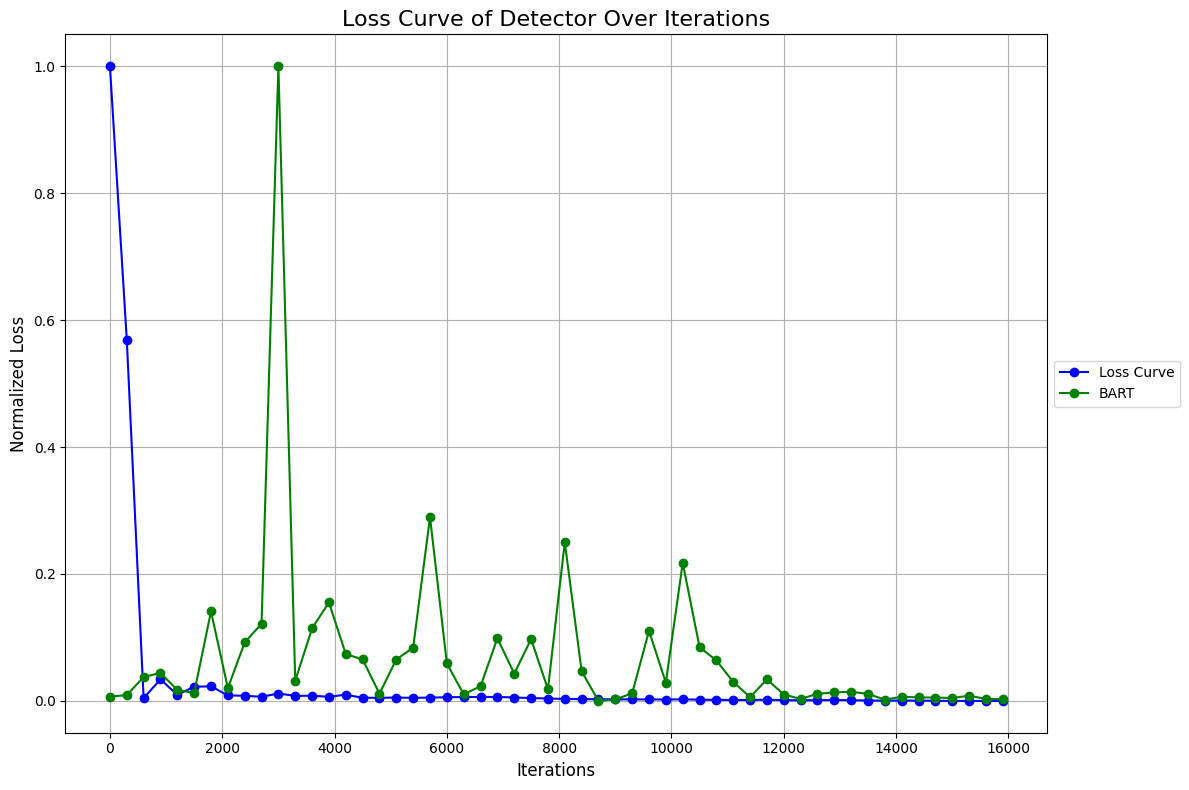

In [25]:
plt.figure(figsize=(12, 8))

iterations = list(np.arange(len(loss_detector))*300)

ppotrainersteps_normalized = (ppotrainersteps - np.min(ppotrainersteps)) / (np.max(ppotrainersteps) - np.min(ppotrainersteps))
loss_detector = (loss_detector - np.min(loss_detector)) / (np.max(loss_detector) - np.min(loss_detector))

plt.plot(iterations, loss_detector, marker='o', linestyle='-', color='b', label='Loss Curve')
plt.plot(iterations, ppotrainersteps_normalized, marker='o', linestyle='-', color='g', label='BART')

plt.title('Loss Curve of Detector Over Iterations', fontsize=16)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Normalized Loss', fontsize=12)
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [30]:
# remove cluttering data so that the session does not crash
%who

AI_text_corpus	 AdamW	 AutoModelForCausalLMWithValueHead	 AutoModelForSeq2SeqLM	 AutoModelForSeq2SeqLMWithValueHead	 AutoModelForSequenceClassification	 AutoTokenizer	 F	 PPOConfig	 
PPOTrainer	 alt_df	 batch_size	 classify_text	 create_reference_model	 dataset	 detector_model	 detector_tokenizer	 device	 
df	 epsilon	 gamma	 get_paraphrase	 human_text_corpus	 inputs_h	 inputs_m	 ip	 iterations	 
json	 labels_h	 labels_m	 lambda_val	 learning_rate	 load_dataset	 logging	 loss	 loss_detector	 
loss_h	 loss_m	 max_steps	 np	 old_action_prob	 op	 optim	 optimizer	 outputs	 
para_ref	 paraphrased_text	 paraphraser_model	 paraphraser_optimizer	 paraphraser_tokenizer	 pd	 plt	 ppo_config	 ppo_trainer	 
ppotrainersteps	 ppotrainersteps_normalized	 query_tensor	 random	 resp_tensor	 respond_to_batch	 reward	 sample_size	 saved_detector_model	 
saved_paraphraser_model	 step	 torch	 train_stats	 validate_df	 validation_data	 warnings	 x_h	 x_m	 
x_p_texts	 


In [27]:
del AI_text
del copy_df
del batch_size
del classify_text
del create_reference_model
del dataset
del df 
del epsilon
del gamma
del get_paraphrase
del human_text
del inputs_h
del inputs_m
del ip
del iterations 
del labels_h
del labels_m
del lambda_val
del learning_rate
del load_dataset
del logging
del loss
del loss_detector
del loss_h
del loss_m
del max_steps
del op
del optim
del optimizer
del outputs
del para_ref 
del paraphrased_text
del paraphraser_model
del paraphraser_optimizer
del paraphraser_tokenizer
del ppo_config
del ppo_trainer 
del ppotrainersteps
del ppotrainersteps_normalized
del query_tensor
del random
del resp_tensor
del respond_to_batch
del reward
del step
del train_stats
del x_h
del x_m
del x_p_texts

In [31]:
scores = []
dt_od = detector_model
for i in tqdm(validate_df['wiki_intro'][:300]):
  tok = detector_tokenizer(i,return_tensors="pt",padding = True,truncation = True)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
print('Done wiki')

for i in tqdm(validate_df['generated_intro'][:300]):
  tok = detector_tokenizer(i,return_tensors="pt",padding = True,truncation = True)
  logits = dt_od(**tok).logits
  scores.append(1 if logits[0][0]>0.8 else 0)
print('Done generated')

100%|██████████| 300/300 [09:26<00:00,  1.89s/it]


Done wiki


100%|██████████| 300/300 [06:45<00:00,  1.35s/it]

Done generated


In [35]:
labels = [1]*300 + [0]*300

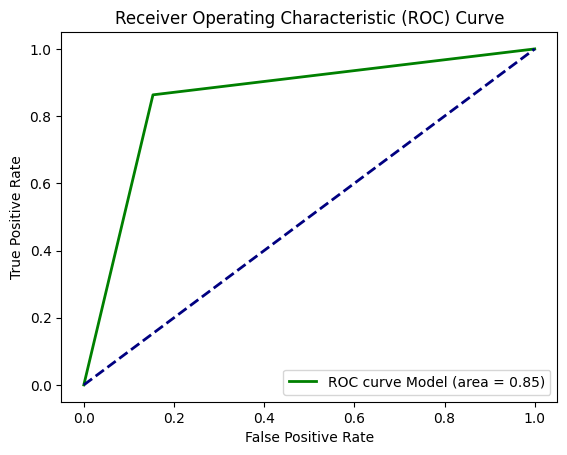

AUROC: 0.855
Accuracy: 0.855
Precision: 0.8491803278688524
Recall: 0.8633333333333333
F1 score: 0.856198347107438


In [38]:
y_true = labels
y_score = scores

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='g', lw=2, label='ROC curve Model (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print('AUROC:', roc_auc)
print(f'Accuracy: {accuracy_score(y_true, y_score)}')
print(f'Precision: {precision_score(y_true, y_score)}')
print(f'Recall: {recall_score(y_true, y_score)}')
print(f'F1 score: {f1_score(y_true, y_score)}')